# Lesson 1: Homework

Classifing Lego bricks. Dataset available at https://www.kaggle.com/joosthazelzet/lego-brick-images

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

# Training

In [8]:
path = pathlib.Path('/home/ubuntu/LEGO brick images'); path

PosixPath('/home/ubuntu/LEGO brick images')

In [9]:
path.ls()

[PosixPath('/home/ubuntu/LEGO brick images/valid'),
 PosixPath('/home/ubuntu/LEGO brick images/.DS_Store'),
 PosixPath('/home/ubuntu/LEGO brick images/train'),
 PosixPath('/home/ubuntu/LEGO brick images/models')]

In [10]:
fnames = get_image_files(path, recurse=True)

In [11]:
fnames[:5]

[PosixPath('/home/ubuntu/LEGO brick images/valid/3003 Brick 2x2/0117.png'),
 PosixPath('/home/ubuntu/LEGO brick images/valid/3003 Brick 2x2/0291.png'),
 PosixPath('/home/ubuntu/LEGO brick images/valid/3003 Brick 2x2/0134.png'),
 PosixPath('/home/ubuntu/LEGO brick images/valid/3003 Brick 2x2/0266.png'),
 PosixPath('/home/ubuntu/LEGO brick images/valid/3003 Brick 2x2/0198.png')]

In [12]:
data = ImageDataBunch.from_folder(path, size=224, bs=bs).normalize(imagenet_stats)

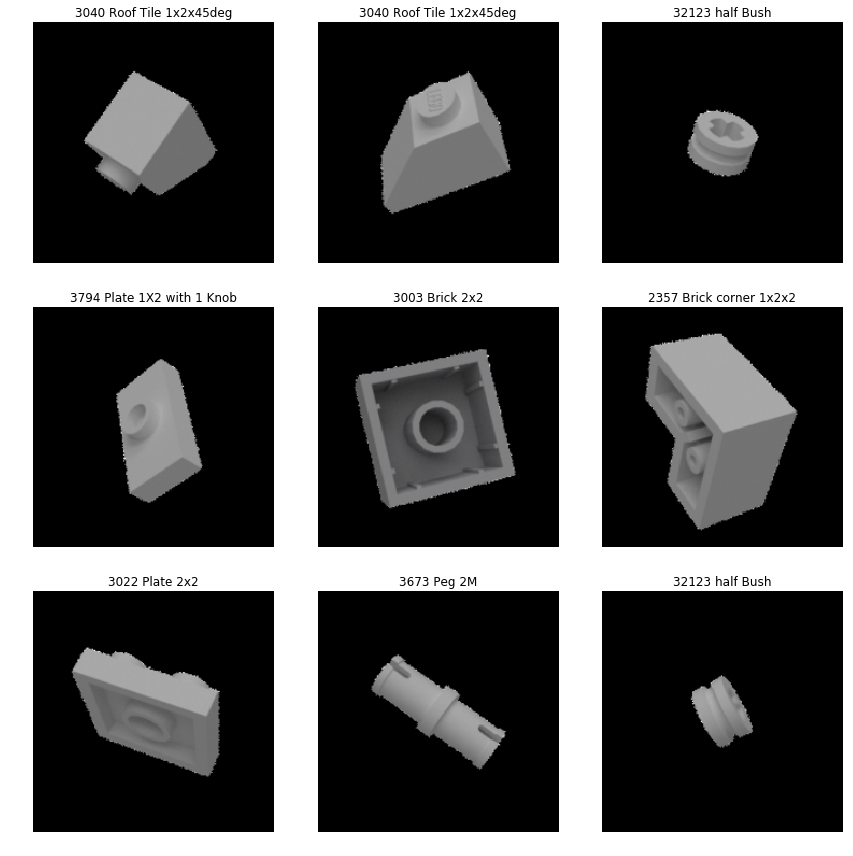

In [13]:
data.show_batch(rows=3)

In [14]:
print(data.classes)
len(data.classes)

['11214 Bush 3M friction with Cross axle', '18651 Cross Axle 2M with Snap friction', '2357 Brick corner 1x2x2', '3003 Brick 2x2', '3004 Brick 1x2', '3005 Brick 1x1', '3022 Plate 2x2', '3023 Plate 1x2', '3024 Plate 1x1', '3040 Roof Tile 1x2x45deg', '3069 Flat Tile 1x2', '32123 half Bush', '3673 Peg 2M', '3713 Bush for Cross Axle', '3794 Plate 1X2 with 1 Knob', '6632 Technic Lever 3M']


16

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.190641,0.224023,0.075560,01:03
1,0.487467,0.108672,0.035742,01:00
2,0.233594,0.046174,0.011130,01:00
3,0.148710,0.037097,0.008309,01:00


In [38]:
learn.save('stage-1')

# Results

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

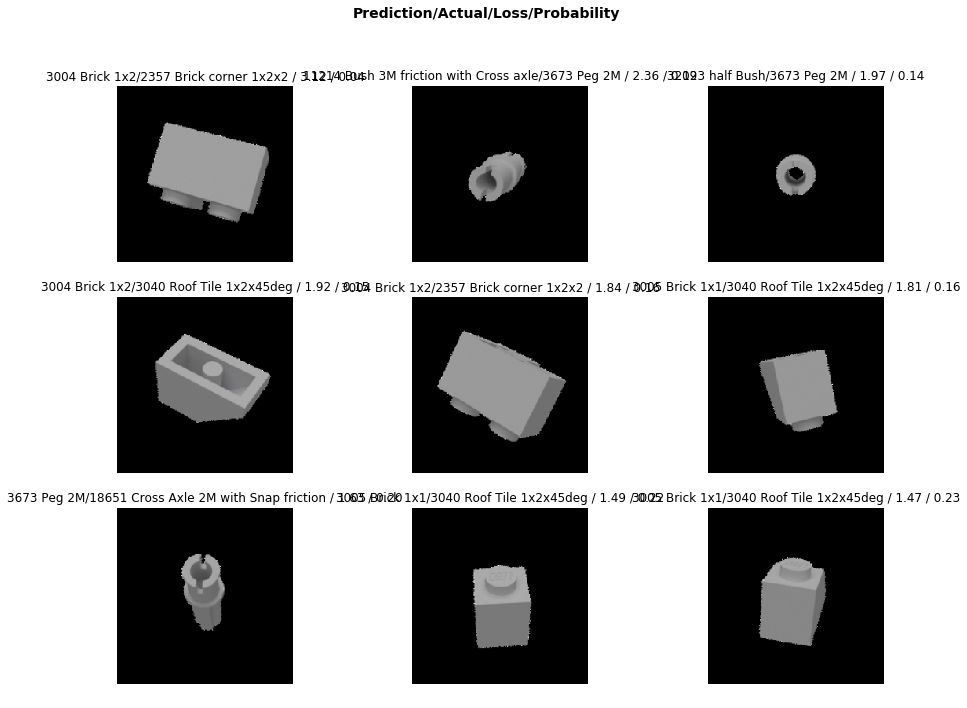

In [40]:
interp.plot_top_losses(9, figsize=(15,11))

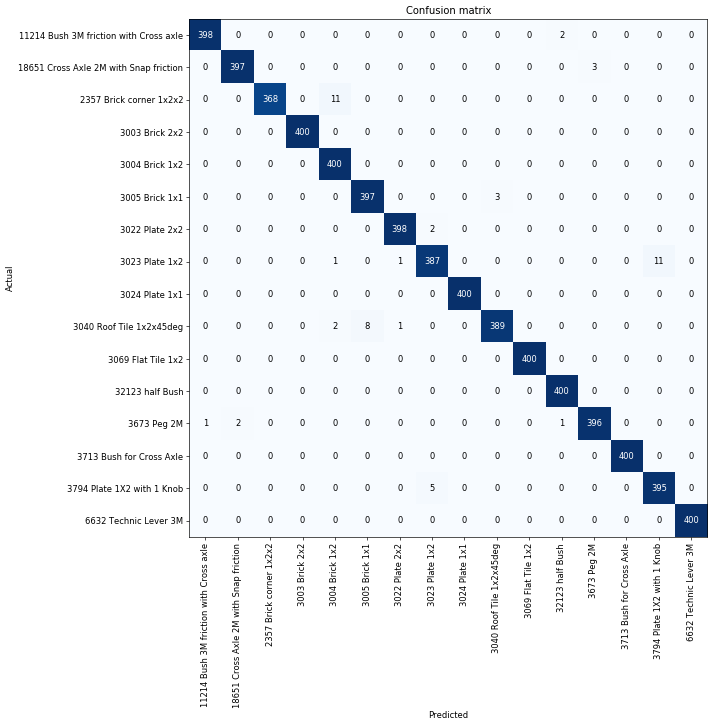

In [41]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
interp.most_confused(min_val=2)

[('2357 Brick corner 1x2x2', '3004 Brick 1x2', 11),
 ('3023 Plate 1x2', '3794 Plate 1X2 with 1 Knob', 11),
 ('3040 Roof Tile 1x2x45deg', '3005 Brick 1x1', 8),
 ('3794 Plate 1X2 with 1 Knob', '3023 Plate 1x2', 5),
 ('18651 Cross Axle 2M with Snap friction', '3673 Peg 2M', 3),
 ('3005 Brick 1x1', '3040 Roof Tile 1x2x45deg', 3),
 ('11214 Bush 3M friction with Cross axle', '32123 half Bush', 2),
 ('3022 Plate 2x2', '3023 Plate 1x2', 2),
 ('3040 Roof Tile 1x2x45deg', '3004 Brick 1x2', 2),
 ('3673 Peg 2M', '18651 Cross Axle 2M with Snap friction', 2)]

# Improving the Results

In [44]:
learn.unfreeze()

In [45]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.291339,0.072044,0.027747,01:19


In [46]:
learn.load('stage-1');

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


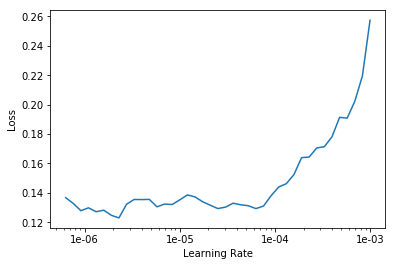

In [48]:
learn.recorder.plot()

In [49]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.121069,0.021103,0.003606,01:19
1,0.081982,0.013928,0.001568,01:19
